ANÁLISIS DEL SENTIMIENTO DEL DATASET DE INSTRUMENTOS MUSICALES.

-LIBRERIAS NECESARIAS-

In [ ]:
! wget https://transfer.sh/kJRtoA/requirements.txt

--2022-07-03 11:39:37--  https://transfer.sh/kJRtoA/requirements.txt
Resolving transfer.sh (transfer.sh)... 144.76.136.153, 2a01:4f8:200:1097::2
Connecting to transfer.sh (transfer.sh)|144.76.136.153|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 236 [text/plain]
Saving to: ‘requirements.txt’

requirements.txt    100%[===================>]     236  --.-KB/s    in 0s      

2022-07-03 11:39:37 (36.3 MB/s) - ‘requirements.txt’ saved [236/236]



In [ ]:
! pip install -r requirements.txt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 132 kB 5.2 MB/s 
     |████████████████████████████████| 101 kB 9.9 MB/s 
     |████████████████████████████████| 1.7 MB 49.9 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 965 kB 40.8 MB/s 
  Created wheel for jellyfish: filename=jellyfish-0.9.0-cp37-cp37m-linux_x86_64.whl size=73978 sha256=3325908239764afa32ba461436ca727a1e357f6034baa36206a5bb30280bb06b
  Stored in directory: /root/.cache/pip/wheels/fe/99/4e/646ce766df0d070b0ef04db27aa11543e2767fda3075aec31b
  Created wheel for pyDAWG: filename=pyDAWG-1.0.1-cp37-cp37m-linux_x86_64.whl size=59249 sha256=2043ecd3dc97a4524156867327664d8503a88e3697fa0d1f8bdd7bf2a83f32be
  Stored in directory: /root/.cache/pip/wheels/85/44/a6/c2ae20c57d8

In [5]:
import random
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.feature_selection import chi2
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, precision_recall_curve

import matplotlib.pyplot as plt

# ***1.DESCARGA Y EDA***

In [ ]:
#Descargo el dataset
! wget http://snap.stanford.edu/data/amazon/productGraph/categoryFiles/reviews_Musical_Instruments_5.json.gz

--2022-07-03 11:40:20--  http://snap.stanford.edu/data/amazon/productGraph/categoryFiles/reviews_Musical_Instruments_5.json.gz
Resolving snap.stanford.edu (snap.stanford.edu)... 171.64.75.80
Connecting to snap.stanford.edu (snap.stanford.edu)|171.64.75.80|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2460495 (2.3M) [application/x-gzip]
Saving to: ‘reviews_Musical_Instruments_5.json.gz’

reviews_Musical_Ins 100%[===================>]   2.35M  2.31MB/s    in 1.0s    

2022-07-03 11:40:22 (2.31 MB/s) - ‘reviews_Musical_Instruments_5.json.gz’ saved [2460495/2460495]



In [152]:
#Lo leo.
import pandas as pd
df =pd.read_json("reviews_Musical_Instruments_5.json.gz", lines=True, compression="gzip")

In [153]:
#Echo un vistazo a que columnas tiene.
df.head()

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime
0,A2IBPI20UZIR0U,1384719342,"cassandra tu ""Yeah, well, that's just like, u...","[0, 0]","Not much to write about here, but it does exac...",5,good,1393545600,"02 28, 2014"
1,A14VAT5EAX3D9S,1384719342,Jake,"[13, 14]",The product does exactly as it should and is q...,5,Jake,1363392000,"03 16, 2013"
2,A195EZSQDW3E21,1384719342,"Rick Bennette ""Rick Bennette""","[1, 1]",The primary job of this device is to block the...,5,It Does The Job Well,1377648000,"08 28, 2013"
3,A2C00NNG1ZQQG2,1384719342,"RustyBill ""Sunday Rocker""","[0, 0]",Nice windscreen protects my MXL mic and preven...,5,GOOD WINDSCREEN FOR THE MONEY,1392336000,"02 14, 2014"
4,A94QU4C90B1AX,1384719342,SEAN MASLANKA,"[0, 0]",This pop filter is great. It looks and perform...,5,No more pops when I record my vocals.,1392940800,"02 21, 2014"


In [154]:
#Me voy a centrar en el análisis del sentimiento, así que sólo voy a prestar atención a la columna de estrellas(overall) y de reviewText
not_useful_columns = [
    'reviewerID', 'asin', 'reviewerName', 'helpful', 'summary', 'unixReviewTime', 
    'reviewTime'
]

df.drop(not_useful_columns, axis=1, inplace=True)

In [155]:
df.head()

,reviewText,overall
0,"Not much to write about here, but it does exac...",5
1,The product does exactly as it should and is q...,5
2,The primary job of this device is to block the...,5
3,Nice windscreen protects my MXL mic and preven...,5
4,This pop filter is great. It looks and perform...,5


In [156]:
len(df)

10261

In [157]:
#Borro las que estén vacias
df.dropna(subset=['reviewText', 'overall'], inplace=True)
df.reset_index(drop=True, inplace=True)

In [158]:
len(df)

10261

In [159]:
#No había ninguna vacia, voy a utilizar 10261 muestras

In [160]:
#Miro las estrellas
df.overall.unique()

array([5, 3, 4, 2, 1])

In [161]:
#Hago una clasificación binaria para simplificar:menos de 3 estrellas review negativa y 3 o más positiva
def label_overall(row):
    if int(row['overall']) < 3:
        return 1
    else:
        return 0

In [162]:
df['sentiment_label'] = df.apply(lambda row: label_overall(row), axis=1)

In [163]:
df.head()

,reviewText,overall,sentiment_label
0,"Not much to write about here, but it does exac...",5,0
1,The product does exactly as it should and is q...,5,0
2,The primary job of this device is to block the...,5,0
3,Nice windscreen protects my MXL mic and preven...,5,0
4,This pop filter is great. It looks and perform...,5,0


- NÚMERO DE REVIEWS POSITIVAS Y NEGATIVAS

In [164]:
len(df)

10261

In [165]:
df["sentiment_label"].sum()

467

In [19]:
#Sólo hay 467 Reviews negativas con menos de 3 estrellas. El modelo va a estar bastante desbalanceado.

In [166]:
#Ahora le echo un ojo al texto
df.reviewText

0        Not much to write about here, but it does exac...
1        The product does exactly as it should and is q...
2        The primary job of this device is to block the...
3        Nice windscreen protects my MXL mic and preven...
4        This pop filter is great. It looks and perform...
                               ...                        
10256              Great, just as expected.  Thank to all.
10257    I've been thinking about trying the Nanoweb st...
10258    I have tried coated strings in the past ( incl...
10259    Well, MADE by Elixir and DEVELOPED with Taylor...
10260    These strings are really quite good, but I wou...
Name: reviewText, Length: 10261, dtype: object

- CARDINALIDAD DEL VOCABULARIO: Vamos a ver cuales son las palabras más frecuentes.

In [167]:
from collections import Counter
import nltk

In [168]:
text = str(df.reviewText)

In [169]:
words_nltk = text.lower().split()

In [170]:
words_nltk[:10]

['0', 'not', 'much', 'to', 'write', 'about', 'here,', 'but', 'it', 'does']

In [171]:
wf = Counter(words_nltk)

In [172]:
wf_most_common = wf.most_common(25)

In [173]:
wf_most_common

[('the', 4),
 ('and', 4),
 ('to', 3),
 ('it', 3),
 ('is', 3),
 ('about', 2),
 ('but', 2),
 ('does', 2),
 ('as', 2),
 ('this', 2),
 ('i', 2),
 ('strings', 2),
 ('0', 1),
 ('not', 1),
 ('much', 1),
 ('write', 1),
 ('here,', 1),
 ('exac...', 1),
 ('1', 1),
 ('product', 1),
 ('exactly', 1),
 ('should', 1),
 ('q...', 1),
 ('2', 1),
 ('primary', 1)]

In [174]:
words = [w[0] for w in wf_most_common]
freqs = [w[1] for w in wf_most_common]

In [175]:
freqs, words = zip(*sorted(zip(freqs, words)))

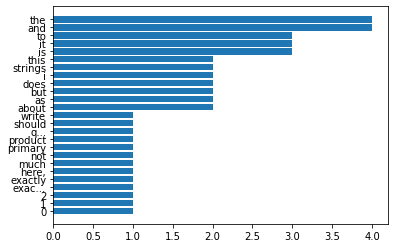

In [176]:
plt.barh(words, freqs)
plt.show()

In [ ]:
#podemos observar que la mayoria se las palabras más frecuentes son stopwords y se repites hasta 4 veces.

In [177]:
#Ahora lo vamos a repetir quitando las stopwords:
!pip install stop_words

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [178]:
from stop_words import get_stop_words

In [179]:
import nltk
nltk.download("stopwords")
from nltk.corpus import stopwords 

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [180]:
nltk_sw_list = stopwords.words('english')

In [181]:
words_noSW = [w[0] for w in wf_most_common if w[0] not in nltk_sw_list]
freqs_noSW = [w[1] for w in wf_most_common if w[1] not in nltk_sw_list]

In [182]:
freqs_noSW, words_noSW = zip(*sorted(zip(freqs_noSW, words_noSW)))

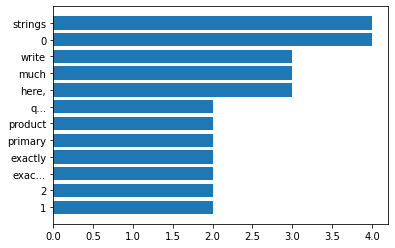

In [183]:
plt.barh(words_noSW, freqs_noSW)
plt.show()

- N-GRAMS MÁS FRECUENTES

In [184]:
from sklearn.feature_extraction.text import CountVectorizer
from nltk import ngrams
from nltk.probability import FreqDist

In [185]:
bigrams_ = list(ngrams(words_nltk, 2))
trigrams_ = list(ngrams(words_nltk, 3))

In [186]:
bigrams_[:10]

[('0', 'not'),
 ('not', 'much'),
 ('much', 'to'),
 ('to', 'write'),
 ('write', 'about'),
 ('about', 'here,'),
 ('here,', 'but'),
 ('but', 'it'),
 ('it', 'does'),
 ('does', 'exac...')]

In [187]:
trigrams_[:10]

[('0', 'not', 'much'),
 ('not', 'much', 'to'),
 ('much', 'to', 'write'),
 ('to', 'write', 'about'),
 ('write', 'about', 'here,'),
 ('about', 'here,', 'but'),
 ('here,', 'but', 'it'),
 ('but', 'it', 'does'),
 ('it', 'does', 'exac...'),
 ('does', 'exac...', '1')]

In [188]:
bg_freq = FreqDist(bigrams_)
tg_freq = FreqDist(trigrams_)

In [189]:
bg_freq.most_common(10)

[(('0', 'not'), 1),
 (('not', 'much'), 1),
 (('much', 'to'), 1),
 (('to', 'write'), 1),
 (('write', 'about'), 1),
 (('about', 'here,'), 1),
 (('here,', 'but'), 1),
 (('but', 'it'), 1),
 (('it', 'does'), 1),
 (('does', 'exac...'), 1)]

In [190]:
tg_freq.most_common(10)

[(('0', 'not', 'much'), 1),
 (('not', 'much', 'to'), 1),
 (('much', 'to', 'write'), 1),
 (('to', 'write', 'about'), 1),
 (('write', 'about', 'here,'), 1),
 (('about', 'here,', 'but'), 1),
 (('here,', 'but', 'it'), 1),
 (('but', 'it', 'does'), 1),
 (('it', 'does', 'exac...'), 1),
 (('does', 'exac...', '1'), 1)]

In [191]:
bg_freq_most_common = bg_freq.most_common(10)
bgs_ = [str(bg[0]) for bg in bg_freq_most_common]
bgs_f_ = [bg[1] for bg in bg_freq_most_common]

tg_freq_most_common = tg_freq.most_common(10)
tgs_ = [str(tg[0]) for tg in tg_freq_most_common]
tgs_f_ = [tg[1] for tg in tg_freq_most_common]

In [192]:
bgs_f_, bgs_ = zip(*sorted(zip(bgs_f_, bgs_)))
tgs_f_, tgs_ = zip(*sorted(zip(tgs_f_, tgs_)))

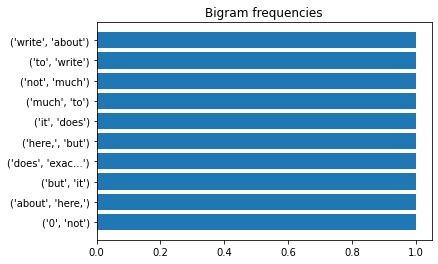

In [193]:
plt.barh(bgs_, bgs_f_)
plt.title('Bigram frequencies')
plt.show()

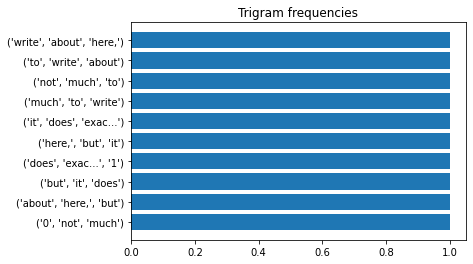

In [194]:
plt.barh(tgs_, tgs_f_)
plt.title('Trigram frequencies')
plt.show()

En esta visualización no termino de entender porque la frecuencia es siempre 1, pues tengo bastantes muestras (10000).

- WORD CLOUD
Visualizamos las palabras más frecuentes.A mayor frecuencia mayor tamaño.

In [49]:
! pip install wordcloud

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [50]:
from wordcloud import WordCloud
from wordcloud import WordCloud, STOPWORDS


In [51]:
#sentiment_label = 0 positivo; sentiment_label = 1 negativo

positivo = df[df["sentiment_label"] == 0]
negativo = df[df["sentiment_label"] == 1]

In [52]:
text_positivo = str(positivo.reviewText)

In [53]:
text_positivo_sinsw = str(positivo.reviewText)

In [54]:
text_negativo = str(negativo.reviewText)

In [55]:
text_negativo_sinsw = str(negativo.reviewText)

In [56]:
# wordcloud de las reviews positivas
def plot_word_cloud(text_positivo):
    wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(' '.join(text_positivo))
    plt.figure(figsize=(12,6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()

In [57]:
words_list = text_positivo.lower().strip().split()

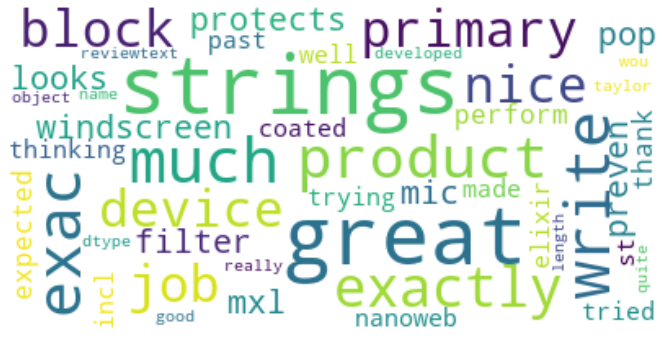

In [58]:
plot_word_cloud(words_list)

In [59]:
# wordcloud de las reviews positivas sin stopwords

def plot_word_cloud(text_positivo_sinsw):
    
  wordcloud = WordCloud(max_font_size=50,stopwords = STOPWORDS.update(['reviewtext','strings','write']) , max_words=50, background_color="white").generate(' '.join(text_positivo_sinsw))
  stopwords = STOPWORDS.update(['reviewtext','sometime','ones'])
  plt.figure( figsize=(12,6))
  plt.imshow(wordcloud, interpolation='bilinear')
  plt.axis('off')
  plt.show()  



In [60]:
words_list = text_positivo_sinsw.lower().strip().split()

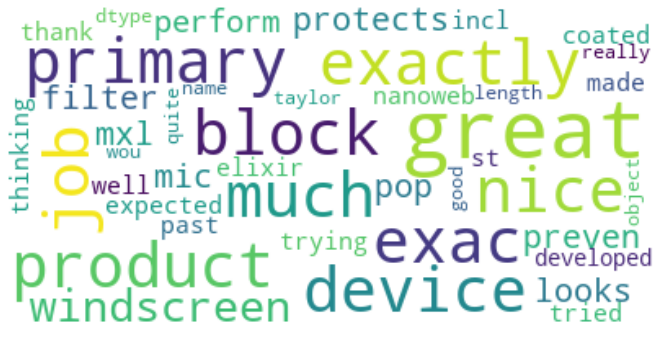

In [61]:
plot_word_cloud(words_list)

In [62]:
# wordcloud de las reviews negativas
def plot_word_cloud(text_negativo):
    wordcloud = WordCloud(max_font_size=50, max_words= 50, background_color="black").generate(' '.join(text_negativo))
    plt.figure(figsize=(12,6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()

In [63]:
words_list = text_negativo.lower().strip().split()

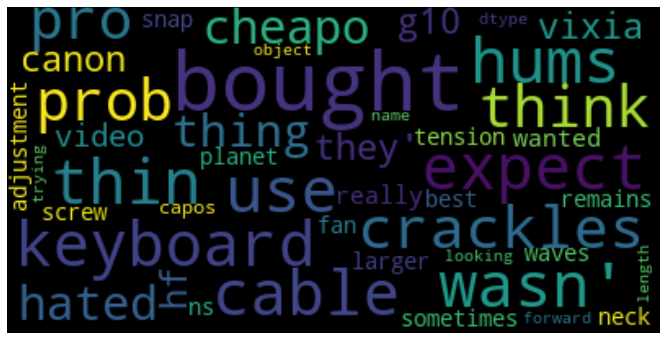

In [64]:
plot_word_cloud(words_list)

In [65]:
# wordcloud de las reviews negativas sin stopwords
def plot_word_cloud(text_negativo_sinsw):
    
    wordcloud = WordCloud(max_font_size=50,stopwords = STOPWORDS.update(['reviewtext','sometime','ones']) , max_words=50, background_color="black").generate(' '.join(text_negativo_sinsw))
    stopwords = STOPWORDS.update(['reviewtext','sometime','ones'])
    plt.figure( figsize=(12,6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()

In [66]:
words_list = text_negativo_sinsw.lower().strip().split()


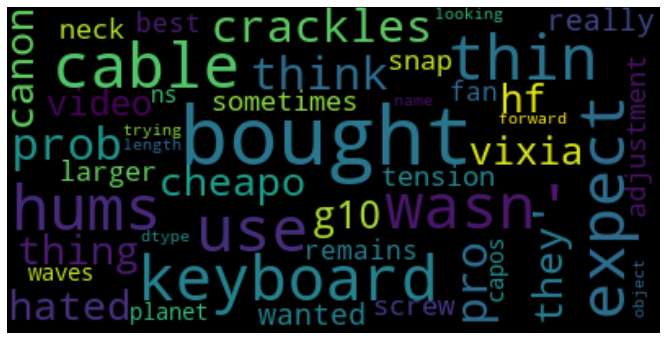

In [67]:
plot_word_cloud(words_list)

- WORD EMBEDDINGS

In [195]:
import numpy as np
from sklearn.manifold import TSNE
from gensim.models import Word2Vec
from gensim.models.word2vec import LineSentence

In [196]:
corpus = df.reviewText.tolist()

In [197]:
documents = [_text.split() for _text in df.reviewText]

In [198]:
cbow_params = {
    'sg': 0,
    'size': 300,
    'min_count': 4,
    'window': 5,
    'hs': 0,
    'negative': 20
}

w2v_cbow = Word2Vec(**cbow_params)

In [199]:
#GENERO WORD2VECT
# CBOW
w2v_cbow = Word2Vec(**cbow_params)

In [200]:
#GENERO EL VOCABULARIO
# CBOW
w2v_cbow.build_vocab(documents)

In [201]:
print('Vocabulario compuesto por {} palabras'.format(len(w2v_cbow.wv.vocab)))

Vocabulario compuesto por 11406 palabras


In [202]:
#Entrenamos los pesos de los embeddngs

# CBOW
w2v_cbow.train(sentences=corpus, total_examples=w2v_cbow.corpus_count, epochs=1)

(2731884, 4986118)

In [203]:
keys = ['music', 'instruments', "keyboard", "cable"]

embedding_clusters = []
word_clusters = []
for word in keys:
    embeddings = []
    words = []
    for similar_word, _ in w2v_cbow.wv.most_similar(word, topn=10):
        words.append(similar_word)
        embeddings.append(w2v_cbow.wv[similar_word])
    embedding_clusters.append(embeddings)
    word_clusters.append(words)

In [204]:
#vamos a ver las palabras mas parecidas
print(word_clusters)

[['etc...', 'static', 'perfectly', '50%', 'inside,', 'Would', 'secured', 'Ampeg,', 'buckle', "it's"], ['tune,', 'that).', 'work.', 'plug.', 'forces', 'CS400', 'shines.', 'intrigued', 'Pay', '"How'], ['website', 'modern', 'Seymour', 'pages', 'natural.', 'channel.', 'matter,', 'smudges', 'cotton,', 'great,'], ['adjustable', 'background,', 'doesnt', 'mounts', 'normal', 'trunk', 'asked', 'recommended', 'option,', '120']]


In [205]:
#Reducimos la dimensionalidad a 2D para poder visualizarlo
tsne_model_2d = TSNE(perplexity=15, n_components=2, init='pca', n_iter=3500, random_state=32)

In [206]:
embedding_clusters = np.array(embedding_clusters)
n, m, k = embedding_clusters.shape

In [207]:
embeddings_2d = np.array(tsne_model_2d.fit_transform(embedding_clusters.reshape(n * m, k))).reshape(n, m, 2)

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:986: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  FutureWarning,


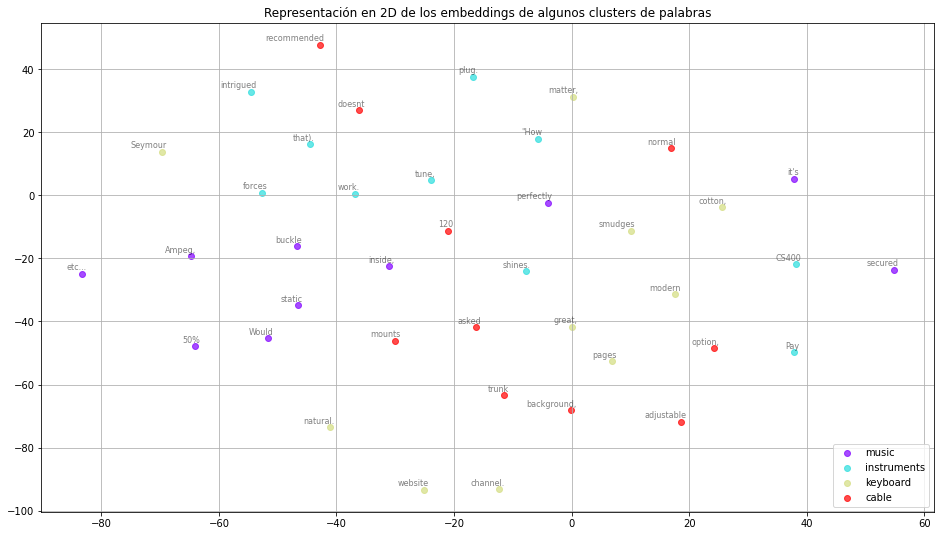

In [208]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
%matplotlib inline


def tsne_plot_similar_words(labels, embedding_clusters, word_clusters, a=0.7):
    plt.figure(figsize=(16, 9))
    colors = cm.rainbow(np.linspace(0, 1, len(labels)))
    for label, embeddings, words, color in zip(labels, embedding_clusters, word_clusters, colors):
        x = embeddings[:,0]
        y = embeddings[:,1]
        plt.scatter(x, y, c=[color], alpha=a, label=label)
        for i, word in enumerate(words):
            plt.annotate(word, alpha=0.5, xy=(x[i], y[i]), xytext=(5, 2), 
                         textcoords='offset points', ha='right', va='bottom', size=8)
    plt.legend(loc=4)
    plt.grid(True)
    plt.title('Representación en 2D de los embeddings de algunos clusters de palabras')
    # plt.savefig("f/г.png", format='png', dpi=150, bbox_inches='tight')
    plt.show()


tsne_plot_similar_words(keys, embeddings_2d, word_clusters)

-Es interesante ver como los topics de music están colocado en la parte central, más cercano a los demás.

# ***2.PREPROCESAMIENTO***

In [82]:
! pip install num2words

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [83]:
! pip install wordnet

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [84]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [85]:
nltk.download('omw-1.4')

[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [95]:
#VAMOS A UTILIZAR LA LIBRERIA OPEN SOURCE NLTK PARA SIMPLIFICAR EL TRABAJO:
import nltk
import unicodedata
from num2words import num2words

from nltk import RegexpTokenizer
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet


def nltk_cleaner(text, tokenizer, sw_list, lemmatizer):
    clean_text = list()
    
    # ELIMINAMOS ACENTOS, ETC: Tener palabras acentuadas dificulta el trabajo con textos, en nuestro caso
       # nuestras reviews están en inglés, con lo que no necesitaríamos hacerlo, pero por si acaso hay alguna
       # en español lo pasamos.

    text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore') 
    
    # SEPARAMOS PALABRAS, ELIMINANDO SIGNOS DE PUNTUACIÓN:Al estar haciendo un análisis de sentimiento 
              #necesitamos simplificar el texto todo lo que podamos, quitando ruido.

    for word in tokenizer.tokenize(text):
        
        # Elimino stop words: para quitar ruido.
        if word not in sw_list:
            
        # Elimino espacios sobrantes, convierto a minúsculas y lematizo: 
             #Facilitamos al clasificador, le simplificamos el trabajo.
            clean_word = lemmatizer.lemmatize(word).lower().strip()
        
        # Convierto dígitos a palabras, pues el clasificador entiende mejor las palabras.
            if clean_word.isdigit():
                clean_word = num2words(clean_word, lang='en')

            clean_text.append(clean_word)
            
    return ' '.join(clean_text)

In [96]:
tokenizer = RegexpTokenizer(r'\w+')
sw_list = stopwords.words('english')
lemmatizer = WordNetLemmatizer()

In [97]:
cleaned_df = []
for index, row in df.iterrows():
    cleaned_df.append(nltk_cleaner(row["reviewText"],tokenizer, sw_list, lemmatizer))

In [99]:
cleaned_df[10]

'monster make wide array cable including high end initially purchased pair ofmonster rock instrument cable twenty one foot angled straight one four inch plugto use keyboard came time purchase cable bass guitar thought pinch penny glad compared cable model expensive model previously purchased aside look could detect difference sound swapped back forth guitar keyboard ensuring model used instrument still difference expensive model going look sure higher priced model even sturdy molded stress relief end model seem make reliable pricier sibling bottom line carefully compare cable using instrument amp possible making purchase decision may find higher price necessarily equal higher value even manufacturer'

In [ ]:
#tiene buena pinta

# ***3.ENTRENAMIENTO/TEST***

In [100]:
#Separamos train-test
X_train, X_test, y_train, y_test = train_test_split(
    cleaned_df,
    df['sentiment_label'],
    train_size=0.75,
    test_size=0.25,
    random_state=42,
    shuffle=True
)

In [103]:
X_train[:10]

['old ev mics little foam piece inside ball dry rotted crumbled provided easy inexpensive solution complaint',
 'really play around knob find perfect tone able sort dial nice marshall eighty alt rock sound playing noisy wind like feedback coming amp vary amp amp fiddle voice drive knob clear usually result drop overdrive distorted sound perfectly honest pretty impressive sound get le forty',
 'found sometimes cheapy one tend break fairly easily one lasted long time hardly break considering get thin one',
 'called lower priced brother enormous line six fbv shortboard mkii pedal cut still lot feature quality build self powered attached line six modeling amp real nice feature one le power supply hook foot switch easy use built tuner work great volume wah pedal switching requires little effort old pedal still job nicely firm forward press programming pedal really allows fine tune four amp sound instantly available play either home stage',
 'let face sure better compressor three four time p

In [104]:
y_train[:10]

9057    0
9293    0
1721    0
7296    0
5641    0
9251    0
6101    0
6149    0
7342    0
862     0
Name: sentiment_label, dtype: int64

a)VAMOS A EMPEZAR POR LOS MODELOS CLÁSICOS DE MACHINE LEARNING:

In [105]:
#extraemos las features
#Voy a utilizar Tfidf porque tengo mucho datos y quiero que tenga en cuenta frecuencia y peso

import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer


In [106]:
cv = TfidfVectorizer(
    ngram_range=(1, 3),
    strip_accents='ascii',
    max_df=0.95,
    min_df=3,
    max_features=3000
)
cv.fit(X_train)

TfidfVectorizer(max_df=0.95, max_features=3000, min_df=3, ngram_range=(1, 3),
                strip_accents='ascii')

In [107]:
X_train_ = cv.transform(X_train)
X_test_ = cv.transform(X_test)

In [108]:
#a1) MODELO REGRESIÓN LOGÍSTICA

from sklearn.linear_model import LogisticRegression

c_params = [0.01, 0.05, 0.25, 0.5, 1, 10, 100, 1000, 10000]

train_acc = list()
test_acc = list()
for c in c_params:
    lr = LogisticRegression(C=c, solver='lbfgs', max_iter=500)
    lr.fit(X_train_, y_train)
    
    train_predict = lr.predict(X_train_)
    test_predict = lr.predict(X_test_)
    
    print ("Accuracy for C={}: {}".format(c, accuracy_score(y_test, test_predict)))
    
    train_acc.append(accuracy_score(y_train, train_predict))
    test_acc.append(accuracy_score(y_test, test_predict))

Accuracy for C=0.01: 0.9532346063912704
Accuracy for C=0.05: 0.9532346063912704
Accuracy for C=0.25: 0.9532346063912704
Accuracy for C=0.5: 0.9532346063912704
Accuracy for C=1: 0.9532346063912704
Accuracy for C=10: 0.9540140296180826
Accuracy for C=100: 0.9497272018706158
Accuracy for C=1000: 0.9454403741231489
Accuracy for C=10000: 0.9427123928293063


Obtenemos una mayor accuracy con c =10 de 0.9540140296180826

In [110]:
#a2) MODELO GRADIENT BOOSTING CLASSIFIER

from sklearn.ensemble import GradientBoostingClassifier

n_estimators = 32

def classify_gboost(X_train, X_test, y_train, y_test):        
    clf = GradientBoostingClassifier(n_estimators=n_estimators, learning_rate=1.0, max_depth=1, random_state=42)

    clf.fit(X_train, y_train)
    
    print("[{}] Accuracy: train = {}, test = {}".format(
            clf.__class__.__name__,
            clf.score(X_train, y_train),
            clf.score(X_test, y_test)))
    
    return clf


clf2 = classify_gboost(X_train_, X_test_, y_train, y_test)

[GradientBoostingClassifier] Accuracy: train = 0.9551656920077972, test = 0.9532346063912704


Obtenemos un accuracy de train ligeramente inferior, pero practicamente similar.

b) MODELO DEEP LEARNING

In [ ]:
#Voy a utilizar las variables con el TFIDF ya pasado X_train_ y el X_test_

In [126]:
import gensim
import multiprocessing as mp

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Dense,
    Dropout,
    Embedding,
    LSTM,
)
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from sklearn.preprocessing import LabelEncoder

In [127]:
X_train_deep=X_train_.toarray()
X_test_deep=X_test_.toarray()

In [142]:
#hacemos el padding
from keras.preprocessing import sequence

max_words = 500

X_train_gru = sequence.pad_sequences(X_train_deep, maxlen=max_words)
X_test_gru = sequence.pad_sequences(X_test_deep, maxlen=max_words)

X_train_LSTM = sequence.pad_sequences(X_train_deep, maxlen=max_words)
X_test_LSTM = sequence.pad_sequences(X_test_deep, maxlen=max_words)

In [132]:
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense, Dropout, GRUV2, SimpleRNN

#CON GRU
vocabulary_size = 5000
embedding_size = 32
model_gru = Sequential()
model_gru.add(Embedding(vocabulary_size, embedding_size, input_length=max_words))
model_gru.add(GRUV2(100))
model_gru.add(Dense(1, activation='sigmoid'))

print(model_gru.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 500, 32)           160000    
                                                                 
 gru (GRU)                   (None, 100)               40200     
                                                                 
 dense (Dense)               (None, 1)                 101       
                                                                 
Total params: 200,301
Trainable params: 200,301
Non-trainable params: 0
_________________________________________________________________
None


In [135]:
model_gru.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [138]:
batch_size = 64
num_epochs = 1

X_valid, y_valid = X_train_gru[:batch_size], y_train[:batch_size]  # first batch_size samples
X_train2, y_train2 = X_train_gru[batch_size:], y_train[batch_size:]  # rest for training

model_gru.fit(X_train2, y_train2,
          validation_data=(X_valid, y_valid),
          batch_size=batch_size, epochs=num_epochs)

120/120 [==============================] - 94s 746ms/step - loss: 0.2329 - accuracy: 0.9468 - val_loss: 0.0927 - val_accuracy: 0.9844


In [140]:
scores = model_gru.evaluate(X_test_gru, y_test, verbose=1)  # returns loss and other metrics specified in model.compile()
print("Test accuracy:", scores[1])  # scores[1] should correspond to accuracy if you passed in metrics=['accuracy']

81/81 [==============================] - 11s 130ms/step - loss: 0.1890 - accuracy: 0.9532
Test accuracy: 0.9532346129417419


In [133]:
#CON LSTM
vocabulary_size = 5000
embedding_size = 32
model_LSTM = Sequential()
model_LSTM.add(Embedding(vocabulary_size, embedding_size, input_length=max_words))
model_LSTM.add(LSTM(100))
model_LSTM.add(Dense(1, activation='sigmoid'))

print(model_gru.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 500, 32)           160000    
                                                                 
 gru (GRU)                   (None, 100)               40200     
                                                                 
 dense (Dense)               (None, 1)                 101       
                                                                 
Total params: 200,301
Trainable params: 200,301
Non-trainable params: 0
_________________________________________________________________
None


In [141]:
model_LSTM.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [143]:
batch_size = 64
num_epochs = 1

X_valid, y_valid = X_train_LSTM[:batch_size], y_train[:batch_size]  # first batch_size samples
X_train2, y_train2 = X_train_LSTM[batch_size:], y_train[batch_size:]  # rest for training

model_LSTM.fit(X_train2, y_train2,
          validation_data=(X_valid, y_valid),
          batch_size=batch_size, epochs=num_epochs)

120/120 [==============================] - 90s 715ms/step - loss: 0.2200 - accuracy: 0.9547 - val_loss: 0.0911 - val_accuracy: 0.9844


In [146]:
scores = model_LSTM.evaluate(X_test_LSTM, y_test, verbose=1)  # returns loss and other metrics specified in model.compile()
print("Test accuracy:", scores[1])  # scores[1] should correspond to accuracy if you passed in metrics=['accuracy']

81/81 [==============================] - 12s 137ms/step - loss: 0.1893 - accuracy: 0.9532
Test accuracy: 0.9532346129417419


Con el modelo LSTM mejoramos un poquito más la accuracy, pero la mejora es ínfima. Quizás no merezca la pena usar deep learning para este problema.

# ***4.MÉTRICAS Y CONCLUSIONES***

In [147]:
print('\nClassification report:\n{}'.format(classification_report(y_test, test_predict)))


Classification report:
              precision    recall  f1-score   support

           0       0.96      0.98      0.97      2446
           1       0.34      0.23      0.28       120

    accuracy                           0.94      2566
   macro avg       0.65      0.61      0.62      2566
weighted avg       0.93      0.94      0.94      2566



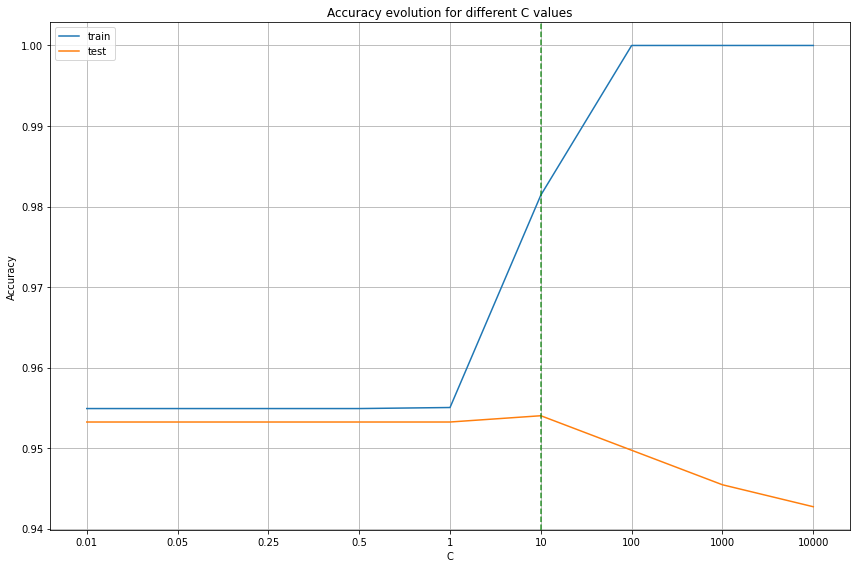

In [148]:
plt.figure(figsize=(12, 8))
plt.plot(train_acc, label='train')
plt.plot(test_acc, label='test')
plt.axvline(np.argmax(test_acc), c='g', ls='--', alpha=0.8)
plt.title('Accuracy evolution for different C values')
plt.xlabel('C')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.xticks(list(range(len(c_params))), c_params)
plt.tight_layout()
plt.show()

CONCLUSIONES
En general obtengo bastantes buenos resultados con un accuracy muy alta en todos los modelos, lo que hace plantearme el problema del overfiting.
El modelo LSTM de deep learning es el que me arroja mejores resultados, pero la mejora es ínfima, así que creo que no merece la pena utilizar deep learning para este problema.
Podría mejorar los resultados balanceando el problema, pues había muchas más muestras positivas que negativas, mejorando el preprocesamien y haciendo más hincapie en las stowords.
